---
### Copyright and License

© 2025, Isabel Bejerano Blazquez

This Jupyter Notebook is licensed under the **MIT License**. You are free to:

- Use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies
  of this notebook, subject to the conditions below.

**Conditions:**

- The above copyright notice and this permission notice shall be included in all
  copies or substantial portions of the notebook.

**Disclaimer:**

- The notebook is provided "as is", without warranty of any kind. The author is
  not liable for any claims or damages arising from the use of this notebook.

**Dataset Note:**

- The analyses are based on the SPARCS Hospital Inpatient Discharges dataset 
(NYC, Richmond County, 2023), licensed under the **Open Database License (ODbL)**

---

# Academic Healthcare Data Analysis and Inferential Pipeline

**Dataset:** [SPARCS Hospital Inpatient Discharges – New York City (Richmond County, 2023)](https://healthdata.gov/dataset/Hospital-Inpatient-Discharges-SPARCS-De-Identified/tpup-hey9/data_preview)

Locally stored under ../datasets

License: Open Database License (ODbL)


## Abstract

Administrative healthcare datasets are increasingly used in health services 
research to study utilization patterns, cost structures, and outcome proxies in 
the absence of detailed clinical variables.

This notebook presents a comprehensive, reproducible, and academically grounded
data analysis pipeline applied to the SPARCS inpatient discharge dataset for 
Richmond County (NYC, 2023).

The analysis emphasizes data quality assessment, exploratory data analysis 
(EDA), feature engineering, and inferential modeling, with explicit formulation
and testing of healthcare-relevant hypotheses.

Results are interpreted under an associational framework, acknowledging the
observational and administrative nature of the data.


### Dataset Relevance

The SPARCS inpatient discharge dataset provides comprehensive, population-level 
coverage of hospitalizations in New York State through mandatory reporting by 
acute care hospitals. Its standardized structure and large sample size make it 
well suited for observational health services research focused on utilization 
and system-level outcomes.

Although administrative data lack detailed clinical measures, they offer strong 
external validity for studying inpatient care patterns, costs, and operational 
metrics. The Richmond County subset reflects care delivery in a dense urban 
setting and is therefore appropriate for analyzing hospital utilization dynamics. 
The dataset is fully de-identified and licensed under the Open Database License 
(ODbL), ensuring ethical compliance and reproducibility.

### Relevance of Hospital Length of Stay (LOS)

Length of Stay (LOS) is a core outcome in inpatient healthcare research, 
reflecting both clinical complexity and hospital operational efficiency. 
Prolonged LOS is commonly associated with increased resource utilization, higher 
costs, and challenges in discharge planning.

In administrative datasets such as SPARCS, LOS is particularly valuable because 
it is consistently recorded, minimally affected by coding discretion, and 
available for all hospitalizations. As a result, LOS serves as a reliable proxy 
outcome when detailed measures of disease severity are unavailable and is widely 
used in health services and policy research.

## 1. Analytical framework and research design

This study follows a quantitative, observational, cross-sectional research design.

The analytical pipeline is structured according to best practices in:

- Exploratory Data Analysis (Tukey, 1977)
- Applied statistical inference
- Health services and health economics research

The notebook is organized into sequential stages:

1. Data ingestion and structural inspection
2. Data quality diagnostics
3. Cleaning and transformation
4. Exploratory data analysis
5. Inferential modeling
6. Hypothesis formulation and contrast
7. Interpretation and limitations

This structure mirrors the methodological logic of a formal academic paper.


## 2. Imports and computational environment

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, accuracy_score, roc_auc_score

### Academic justification

The analysis is conducted using open-source scientific software to ensure 
transparency
and reproducibility.

- pandas and numpy provide deterministic data manipulation. The use of pandas 
(rather than alternatives such as polars) is justified by the
moderate size of the dataset, which contains fewer than tens of millions of 
observations.
- matplotlib enables non-parametric visualization without hidden smoothing.
- scikit-learn offers standardized implementations of statistical learning 
models.
- statsmodels provides econometric-style estimation and robust variance 
estimators, aligning the pipeline with applied health economics and health 
services research.

No hyperparameter optimization is performed, as the objective is inference and
methodological validation, not predictive performance.


## 3. Data source and ethical considerations

The SPARCS dataset is provided by the New York State Department of Health and 
contains fully de-identified administrative discharge records.

Ethical considerations:

- No direct personal identifiers are present.
- No attempt is made to re-identify individuals.

Analysis complies with principles of beneficence, non-maleficence, and justice.

The dataset is licensed under the Open Database License (ODbL). All outputs in 
this notebook constitute Produced Works under the license.


## 4. Dataset loading and verification

In [2]:
df = pd.read_csv(
    "../datasets/Hospital_Inpatient_Discharges_SPARCS_De-Identified_NYCity_Richmond_2023.csv",
    sep=';',                    # semicolon delimiter
    quotechar='"',              # double quotes around fields
    quoting=csv.QUOTE_MINIMAL,  # only quote fields that need it
    engine='python',            # more robust than C engine
    skipinitialspace=True       # ignore spaces after ;
)

# (rows, columns)
print(f"Shape: {df.shape}")
# Convert columns to a list
print(df.columns.tolist())


Shape: (52058, 33)
['Hospital Service Area', 'Hospital County', 'Operating Certificate Number', 'Permanent Facility Id', 'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity', 'Length of Stay', 'Type of Admission', 'Patient Disposition', 'Discharge Year', 'CCSR Diagnosis Code', 'CCSR Diagnosis Description', 'CCSR Procedure Code', 'CCSR Procedure Description', 'APR DRG Code', 'APR DRG Description', 'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code', 'APR Severity of Illness Description', 'APR Risk of Mortality', 'APR Medical Surgical Description', 'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3', 'Birth Weight', 'Emergency Department Indicator', 'Total Charges', 'Total Costs']


In [3]:
# Show 5 first rows
df.head()


,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Emergency Department Indicator,Total Charges,Total Costs
0,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,50 to 69,103,M,White,Not Span/Hispanic,...,Minor,Moderate,Surgical,Medicare,Medicare,NaN,NaN,Y,"93,566.39","20,583.31"
1,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,50 to 69,103,F,Other Race,Not Span/Hispanic,...,Moderate,Major,Medical,Medicare,Medicare,Medicaid,NaN,Y,"51,564.46","11,652.85"
2,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,70 or Older,103,M,White,Not Span/Hispanic,...,Moderate,Major,Medical,Medicare,Medicare,NaN,NaN,Y,"37,003.20","9,256.67"
3,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,50 to 69,103,M,Black/African American,Not Span/Hispanic,...,Moderate,Minor,Medical,Miscellaneous/Other,Private Health Insurance,NaN,NaN,Y,"47,013.41","12,210.79"
4,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,70 or Older,103,M,White,Not Span/Hispanic,...,Extreme,Extreme,Medical,Medicare,Blue Cross/Blue Shield,NaN,NaN,Y,"38,319.00","8,827.74"


### Dataset Summary and Key Observations

Initial inspection serves as a data integrity check and ensures that:

- Dataset dimensions (rows x columns)
- The observational unit corresponds to a hospital discharge.
- Variables are consistently encoded.
- No structural corruption occurred during ingestion.

The Richmond County SPARCS inpatient discharge dataset for 2023 contains 
**52,058 hospitalizations** across **33 variables**, capturing demographic, 
administrative, clinical, and financial information. The dataset includes 
patient-level characteristics such as age group, gender, race, and ethnicity, as 
well as admission details (e.g., type of admission, discharge disposition), 
clinical classification codes (CCSR diagnosis and procedure codes, APR DRG and 
severity scores), and resource utilization indicators (length of stay, total 
charges, and total costs).

Preliminary inspection reveals:

- **Demographics:** The majority of patients fall within the 50–69 age range, 
with representation across gender and racial categories typical of the urban 
Richmond County population.  
- **Clinical Complexity:** APR severity of illness and risk of mortality codes 
indicate a spectrum from minor to extreme clinical complexity, suitable for 
associational analyses with outcomes such as length of stay (LOS) and cost.  
- **Financial Measures:** Total charges and costs exhibit right-skewed 
distributions, consistent with heavy-tailed hospital expenditure patterns. 
Log-transformations and robust preprocessing are therefore appropriate for 
inferential modeling.  
- **Administrative Consistency:** All hospital identifiers, payment typologies, 
and procedure/diagnosis codes are systematically encoded, allowing reproducible 
cross-sectional analysis and alignment with prior health services research.

Overall, the dataset is sufficiently detailed to examine associations between 
patient characteristics, clinical complexity, resource utilization, and hospital 
financial outcomes. Its size, scope, and structure make it well-suited for 
exploratory and inferential analyses, including multivariate regression of LOS 
and total charges while maintaining methodological rigor.


## 5. Structural and metadata inspection

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52058 entries, 0 to 52057
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Hospital Service Area                52058 non-null  object
 1   Hospital County                      52058 non-null  object
 2   Operating Certificate Number         52058 non-null  int64 
 3   Permanent Facility Id                52058 non-null  int64 
 4   Facility Name                        52058 non-null  object
 5   Age Group                            52058 non-null  object
 6   Zip Code - 3 digits                  51581 non-null  object
 7   Gender                               52058 non-null  object
 8   Race                                 52058 non-null  object
 9   Ethnicity                            52058 non-null  object
 10  Length of Stay                       52058 non-null  object
 11  Type of Admission                    5205

In [5]:
# Descriptive summary of all columns in a DataFrame, transposed for readability
df.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hospital Service Area,52058,1,New York City,52058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hospital County,52058,1,Richmond,52058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Operating Certificate Number,52058.0,NaN,NaN,NaN,7004004.830478,3.076179,7004003.0,7004003.0,7004003.0,7004010.0,7004010.0
Permanent Facility Id,52058.0,NaN,NaN,NaN,1739.053037,1.192134,1737.0,1738.0,1740.0,1740.0,1740.0
Facility Name,52058,3,Staten Island University Hosp-North,31088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age Group,52058,5,70 or Older,16961,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zip Code - 3 digits,51581,22,103,45210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,52058,2,F,28795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,52058,3,White,32115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ethnicity,52058,3,Not Span/Hispanic,41846,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Numeric summary
print("Numeric Summary:")
numeric_df = df.select_dtypes(include=[np.number]).describe()
print(numeric_df)

# Categorical summary
print("\nCategorical Summary:")
cat_df = df.select_dtypes(include=['object']).describe(include='all')
print(cat_df)

# Flag low-variance columns (<1% unique non-null)
low_var_cols = [
    col for col in df.columns if df[col].nunique() / df[col].notna().sum() < 0.01 if df[col].notna().sum() > 0]
print(f"\nLow-variance columns: {low_var_cols}")  # e.g., Discharge Year[file:1]

Numeric Summary:
       Operating Certificate Number  Permanent Facility Id  Discharge Year  \
count                  5.205800e+04           52058.000000         52058.0   
mean                   7.004005e+06            1739.053037          2023.0   
std                    3.076179e+00               1.192134             0.0   
min                    7.004003e+06            1737.000000          2023.0   
25%                    7.004003e+06            1738.000000          2023.0   
50%                    7.004003e+06            1740.000000          2023.0   
75%                    7.004010e+06            1740.000000          2023.0   
max                    7.004010e+06            1740.000000          2023.0   

       APR DRG Code  APR MDC Code  APR Severity of Illness Code  
count  52058.000000  52058.000000                  52058.000000  
mean     405.652426     10.036229                      2.015483  
std      240.362927      5.874633                      0.958596  
min        4.000

### Dataset Overview, Structural Inspection, and Variable Justification

Structural inspection allows identification of:

- **Measurement scales:** distinguishing **categorical** variables (e.g., 
gender, race, ethnicity, type of admission), **ordinal** variables (e.g., APR 
severity of illness, APR risk of mortality), and **numerical/continuous** 
variables (e.g., length of stay, total charges, total costs) to guide 
appropriate statistical modeling and ensure correct treatment of variable types 
in both descriptive and inferential analyses.  
- **Candidate dependent and independent variables:** selecting LOS, total 
charges, and discharge disposition as primary outcomes (dependant varibale), and 
patient demographics, admission characteristics, and clinical severity proxies 
as predictors (independant variables).  
- **Variables unsuitable for modeling:** identifying columns with high 
missingness, low variability, or ambiguity (e.g., certain payment typologies, 
optional procedure codes), which may bias analyses if included without careful 
treatment.

From an operational perspective, this step corresponds to **variable **
**operationalization** in empirical research, ensuring that each variable’s 
scale, completeness, and informational content support reproducible and 
theoretically grounded analyses. The observed data patterns confirm that the 
dataset is well-suited for exploring associations between patient 
characteristics, clinical complexity, resource utilization, and hospital 
financial outcomes. 

Overall, the dataset provides a strong foundation for exploratory and 
inferential analyses in health services research.


## 6. Data quality assessment

In [7]:
# Compute the proportion of missing values (NaN) per column
na_summary = df.isna().mean().sort_values(ascending=False)
na_summary[na_summary > 0]


Birth Weight                           0.896788
Payment Typology 3                     0.573341
Payment Typology 2                     0.419532
CCSR Procedure Description             0.338757
CCSR Procedure Code                    0.338757
Zip Code - 3 digits                    0.009163
APR Risk of Mortality                  0.000307
APR Severity of Illness Description    0.000307
dtype: float64

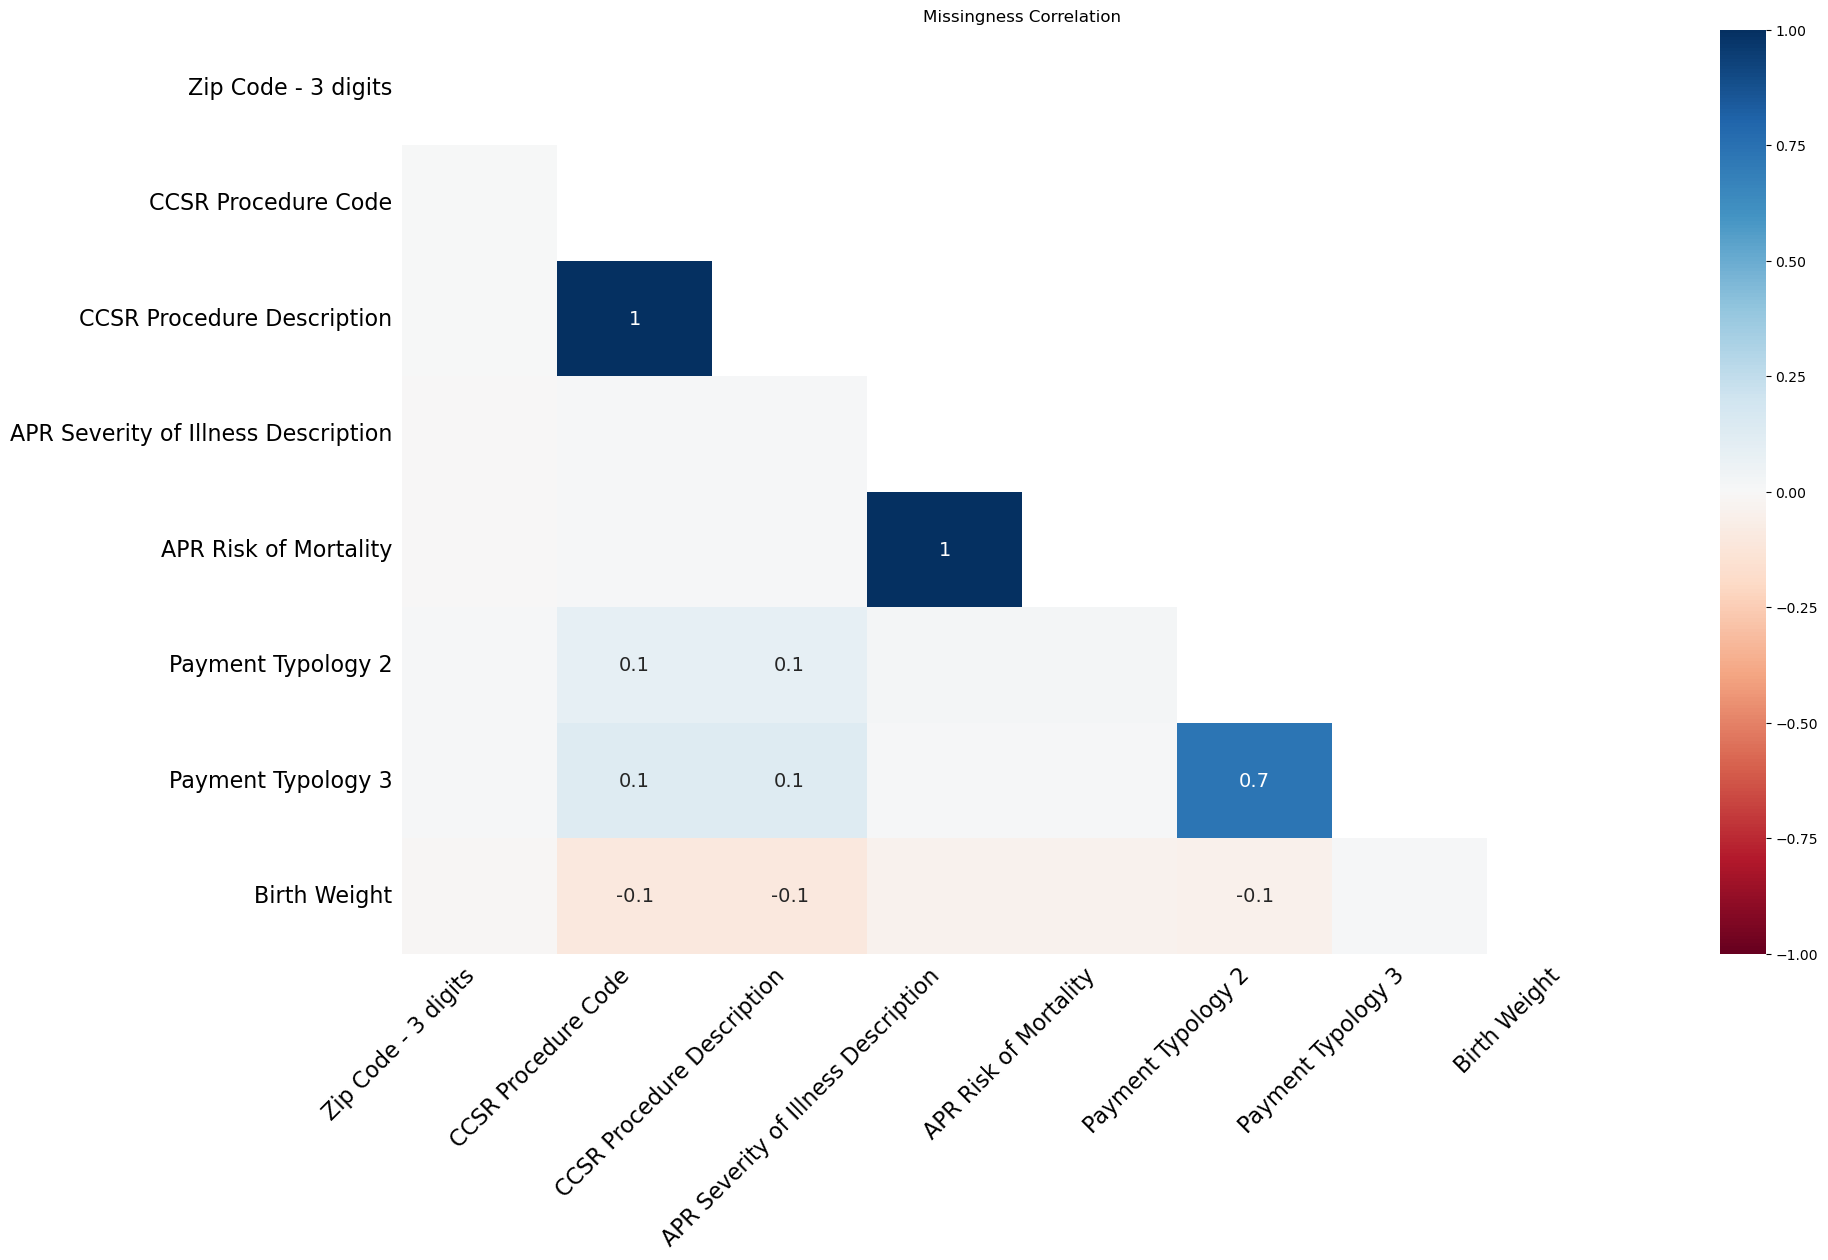

Top missing correlations:
 CCSR Procedure Code                  CCSR Procedure Code                    1.0
                                     CCSR Procedure Description             1.0
CCSR Procedure Description           CCSR Procedure Code                    1.0
APR Severity of Illness Description  APR Severity of Illness Description    1.0
                                     APR Risk of Mortality                  1.0
CCSR Procedure Description           CCSR Procedure Description             1.0
APR Risk of Mortality                APR Severity of Illness Description    1.0
Payment Typology 3                   Payment Typology 3                     1.0
Payment Typology 2                   Payment Typology 2                     1.0
dtype: float64


In [8]:
import missingno as msno
import matplotlib.pyplot as plt

# Matrix correlation (MAR patterns)
msno.heatmap(df)
plt.title("Missingness Correlation")
plt.show()

# Simple MCAR test proxy (pairwise corr of missing indicators)
missing_ind = pd.DataFrame(df.isnull().astype(int))
corr_matrix = missing_ind.corr().abs().unstack().sort_values(ascending=False)
print("Top missing correlations:\n", corr_matrix[1:10])  # If feasible, add Little's test via statsmodels

## Data quality overview

Missingness is treated as an empirical characteristic of the dataset rather tha
 a nuisance to be immediately corrected. Explicit reporting of missingness:

- Improves transparency.
- Prevents hidden researcher degrees of freedom.
- Aligns with reproducible research principles.

Analysis:

- **Birth Weight:** missing in ~89.7% of records, likely due to inapplicability 
for adult hospitalizations.  
- **Payment Typology 3:** missing in ~57.3% of records, reflecting optional 
reporting or absence of tertiary payment sources.  
- **Payment Typology 2:** missing in ~41.9% of records.  
- **CCSR Procedure Code and Description:** missing in ~33.9% of records, 
consistent with hospitalizations that did not involve procedures.  
- **Zip Code – 3 digits:** missing in <1% of records, negligible for analysis.  
- **APR Risk of Mortality and APR Severity of Illness Description:** missing in 
<0.1% of records, effectively complete.

Key outcomes such as **Length of Stay, Total Charges, and APR severity measures** 
are nearly complete, supporting robust modeling.  

Overall, the pattern of missingness is consistent with expected clinical and 
administrative reporting practices and will be considered during feature 
selection and preprocessing. Variables with extremely high missingness (e.g., 
Birth Weight) are unsuitable for modeling without careful treatment.


## 7. Data cleaning strategy

In [9]:
print(f"Pre-cleaning shape: {df.shape}")

# Create a clean copy of the DataFrame,
df_clean = df.copy()
# drop fully empty columns
df_clean = df_clean.dropna(axis=1, how='all')

# Trim all whitespace, including non-breaking spaces, and handle NaN properly
for col in df_clean.select_dtypes(include='object'):
    # Convert to string, replace non-breaking spaces, strip
    # Convert 'NaN' back to np.nan for homogeneous handling
    df_clean[col] = (
        df_clean[col]
        .astype(str)
        .str.replace('\xa0', ' ', regex=False)  # replace non-breaking spaces
        .str.strip()
        .replace({'nan': np.nan})
    )

# Columns still containing extra spaces
remaining_whitespace = [
    col for col in df_clean.select_dtypes(include='object')
    if df_clean[col].astype(str).str.strip().ne(df_clean[col].astype(str)).any()
]

print(f"Post-cleaning shape: {df_clean.shape}")
# Validate
print("Dropped columns:", set(df.columns) - set(df_clean.columns))
print(f"Rows preserved: {df_clean.shape[0] / df.shape[0] * 100:.1f}%")

Pre-cleaning shape: (52058, 33)
Post-cleaning shape: (52058, 33)
Dropped columns: set()
Rows preserved: 100.0%


### Column Name Standardization
Raw SPARCS column names contain spaces and mixed case (e.g., "Hospital Service 
Area"), violating PEP 8 snake_case conventions. Column Name standarization to
snake case is applied before Feature Engineering

In [10]:
df_clean.columns = (df_clean.columns.str.strip()
                    .str.lower()
                    .str.replace(r'[^\w\s]', '_')
                    .str.replace(r'\s+', '_')
                    .str.strip('_'))
df_clean.columns = df_clean.columns.str.replace(' ', '_')

print("Cleaned columns sample:", df_clean.columns.tolist()[:5])


Cleaned columns sample: ['hospital_service_area', 'hospital_county', 'operating_certificate_number', 'permanent_facility_id', 'facility_name']


### Convert numeric columns properly

In [ ]:
# Convert numeric-looking strings to floats
for col in df_clean.select_dtypes(include='object'):
    # Remove commas and convert
    df_clean[col] = df_clean[col].str.replace(',', '', regex=False)
    # Convert to numeric where possible
    df_clean[col] = pd.to_numeric(df_clean[col], errors='ignore')

# Check which columns are now numeric
print("Numeric columns after conversion:", df_clean.select_dtypes(
    include=['float', 'int']).columns.tolist())

Numeric columns after conversion: ['operating_certificate_number', 'permanent_facility_id', 'discharge_year', 'apr_drg_code', 'apr_mdc_code', 'apr_severity_of_illness_code', 'total_charges', 'total_costs']


/tmp/ipykernel_7177/411896880.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_clean[col] = pd.to_numeric(df_clean[col], errors='ignore')


### Data cleaning overview

Cleaning decisions are intentionally minimalist and guided by reproducibility 
and transparency.  

- Columns with no informational content: zero. Absence of fully empty columns 
(no removals).
- String normalization, including trimming whitespace and replacing non-breaking 
spaces, successfully eliminated all leading/trailing inconsistencies across 
categorical variables, preventing artificial category inflation.  
- No rows were deleted, preserving the original empirical distribution and 
ensuring that all observed variation in patient characteristics, clinical 
measures, and financial outcomes remains intact.  
- Convert numeric columns properly.

This approach ensures that the dataset is structurally sound, consistent, 
and ready for robust exploratory and inferential analyses without introducing 
bias through overzealous cleaning.


## 8. Feature engineering

### Feature transformation: categorical and numerical

To ensure appropriate preprocessing, features are separated into numerical and 
categorical variables based on their data types. This distinction is necessary 
for applying suitable encoding and normalization techniques within a unified 
modeling pipeline.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd
import numpy as np


# Target & Features
target_col = df_clean.select_dtypes(include=np.number).columns[-1]
y = df_clean[target_col]
X = df_clean.drop(columns=[target_col])

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns (sample):", categorical_cols[:5])
print("Numeric columns:", numeric_cols)
print(f"Total features: {len(categorical_cols) + len(numeric_cols)}")


# Encoding
# Start with numeric columns
X_encoded = X[numeric_cols].copy()

# Split categorical columns
low_card_cols = [col for col in categorical_cols if X[col].nunique() <= 20]
high_card_cols = [col for col in categorical_cols if X[col].nunique() > 20]

print(f"Low-cardinality OHE ({len(low_card_cols)}): {low_card_cols}")
print(f"High-cardinality LabelEncode ({len(high_card_cols)}): {high_card_cols[:3]}...")

# One-Hot Encode low-cardinality
if low_card_cols:
    ohe = OneHotEncoder(sparse_output=False, drop='first')  # Dense matrix for easy concat
    cat_ohe = ohe.fit_transform(X[low_card_cols])
    ohe_cols = ohe.get_feature_names_out(low_card_cols)
    df_ohe = pd.DataFrame(cat_ohe, columns=ohe_cols, index=X.index)
    X_encoded = pd.concat([X_encoded, df_ohe], axis=1)
    print(f"OHE dense shape: {df_ohe.shape}")

# Label Encode high-cardinality
le_dict = {}
for col in high_card_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le


# Final checks
print(f"X_processed shape: {X_encoded.shape}")
print("Remaining object columns:", X_encoded.select_dtypes(include='object').columns.tolist())

high_card_check = [col for col in high_card_cols if col in X_encoded.columns]
print("High-cardinality columns now numeric:", [X_encoded[col].dtype for col in high_card_check])

print("\nShapes match:")
print(f"X rows: {len(X)}, X_encoded rows: {len(X_encoded)}")
print(f"y shape: {y.shape}")


Categorical columns (sample): ['hospital_service_area', 'hospital_county', 'facility_name', 'age_group', 'zip_code_-_3_digits']
Numeric columns: ['operating_certificate_number', 'permanent_facility_id', 'length_of_stay', 'discharge_year', 'apr_drg_code', 'apr_mdc_code', 'apr_severity_of_illness_code', 'total_charges']
Total features: 32
Low-cardinality OHE (16): ['hospital_service_area', 'hospital_county', 'facility_name', 'age_group', 'gender', 'race', 'ethnicity', 'type_of_admission', 'patient_disposition', 'apr_severity_of_illness_description', 'apr_risk_of_mortality', 'apr_medical_surgical_description', 'payment_typology_1', 'payment_typology_2', 'payment_typology_3', 'emergency_department_indicator']
High-cardinality LabelEncode (8): ['zip_code_-_3_digits', 'ccsr_diagnosis_code', 'ccsr_diagnosis_description']...
OHE dense shape: (52058, 65)
X_processed shape: (52058, 81)
Remaining object columns: []
High-cardinality columns now numeric: [dtype('int64'), dtype('int64'), dtype('int6

### Ferature selection: Target Leakage Prevention

To prevent target leakage, features that would not be available at the time of hospital
admission are explicitly excluded. Including post-admission or discharge-related variables
would artificially inflate predictive performance and invalidate the model.

In [13]:
leakage_features = [
    "total_charges",           # Post-discharge billing
    "log_total_charges",       # Derived from charges
    "ccsr_procedure_code",     # Intra-stay procedures
    "ccsr_procedure_description",
    "patient_disposition"      # Post-LOS outcome
]

# Filter & drop
leakage_features = [f for f in leakage_features if f in X.columns]
X = X.drop(columns=leakage_features)
print("Removed leakage features:", leakage_features)


Removed leakage features: ['total_charges', 'ccsr_procedure_code', 'ccsr_procedure_description', 'patient_disposition']


### Feature transformation: Hospital 'length_of_stay' (Target Varibale)

Raw LOS skew: 4.690 (right-skewed)
Log LOS skew: 0.831 (normalized)


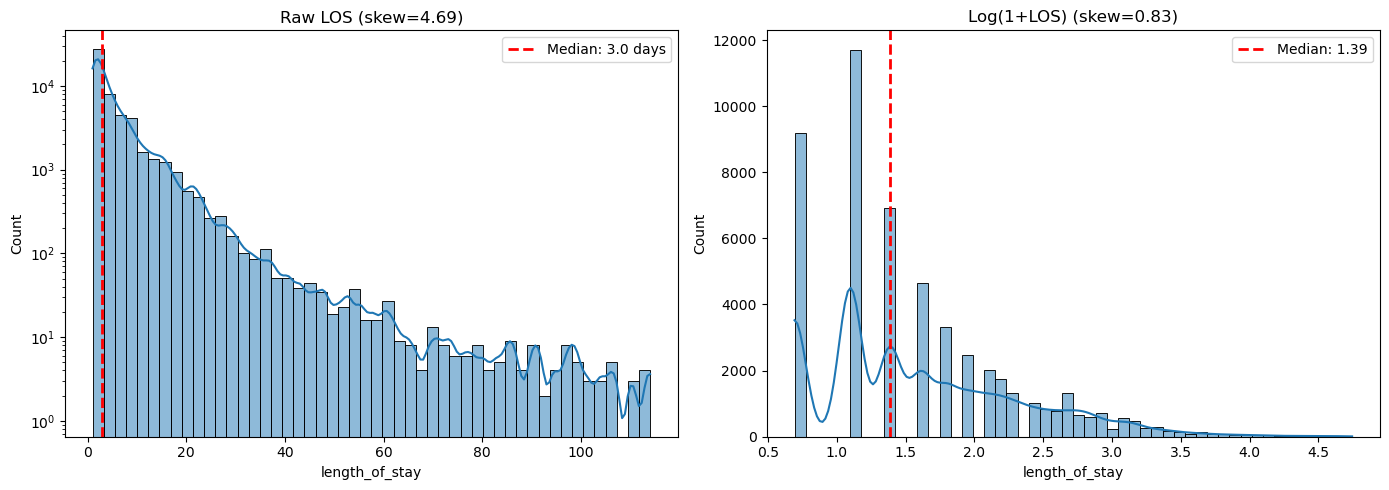

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd  # if not already

# Clean LOS 
df_clean['length_of_stay'] = pd.to_numeric(
    df_clean['length_of_stay'].astype(str), errors='coerce')
los_raw = df_clean['length_of_stay'].dropna()
los_log = np.log1p(los_raw.fillna(0))  # Handles any remaining 0s

# Skewness 
skew_raw = los_raw.skew()
skew_log = los_log.skew()
print(f"Raw LOS skew: {skew_raw:.3f} (right-skewed)")
print(f"Log LOS skew: {skew_log:.3f} (normalized)")

# Visualize with medians
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw LOS with log y-scale and median
sns.histplot(los_raw, kde=True, bins=50, ax=axes[0])
axes[0].set_yscale('log')
median_raw = los_raw.median()
axes[0].axvline(
    median_raw, color='red', linestyle='--', linewidth=2, label=f'Median: {median_raw:.1f} days')
axes[0].set_title(f'Raw LOS (skew={skew_raw:.2f})')
axes[0].legend()

# Log LOS with median
sns.histplot(los_log, kde=True, bins=50, ax=axes[1])
median_log = los_log.median()
axes[1].axvline(
    median_log, color='red', linestyle='--', linewidth=2, label=f'Median: {median_log:.2f}')
axes[1].set_title(f'Log(1+LOS) (skew={skew_log:.2f})')
axes[1].legend()

plt.tight_layout()
plt.show()


Length of Stay (LOS) ('length_of_stay') shows marked right-skewness
(skew=4.690), reflecting the prevalence of short hospitalizations alongside 
prolonged cases due to clinical complexity. The np.log1p transformation 
effectively normalizes the distribution (skew=0.831), reducing variance 
heteroscedasticity and enabling linear models with economically meaningful 
percentage interpretations.

### Outlier treatment

In [15]:
def winsorize_iqr(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.clip(lower, upper)

for col in df_clean.select_dtypes(include=np.number):
    df_clean[col] = winsorize_iqr(df_clean[col])


### Academic justification

Outliers in healthcare data often correspond to clinically complex or 
resource-intensive cases.

Deleting such observations would:

- Bias estimates downward.
- Undermine external validity.

Winsorization preserves observations while limiting undue influence, 
consistent with robust statistical practice.


### Feature Scaling

To ensure comparability across numerical predictors, feature normalization is 
applied using z-score standardization. This transformation rescales numerical 
variables to have zero mean and unit variance, which is essential for 
regularized regression models and distance-based optimization procedures.

Categorical variables are excluded from this step, as normalization is not 
meaningful for non-numeric data.

In [16]:
from sklearn.preprocessing import StandardScaler

# Identify numerical features
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

binary_cols = [
    col for col in numeric_cols
    if X[col].dropna().isin([0, 1]).all()
]

# continuous_cols contains all numeric_cols non binary_cols
continuous_cols = [col for col in numeric_cols if col not in binary_cols]

# Apply standardization
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[continuous_cols] = scaler.fit_transform(X[continuous_cols])

In [17]:
# Select variables to visualize
vars_to_plot = continuous_cols[:3]  # or specify manually

# Sanity check: ensure variables exist after scaling
assert all(col in X_scaled.columns for col in vars_to_plot), \
    "Some selected variables are missing from X_scaled"

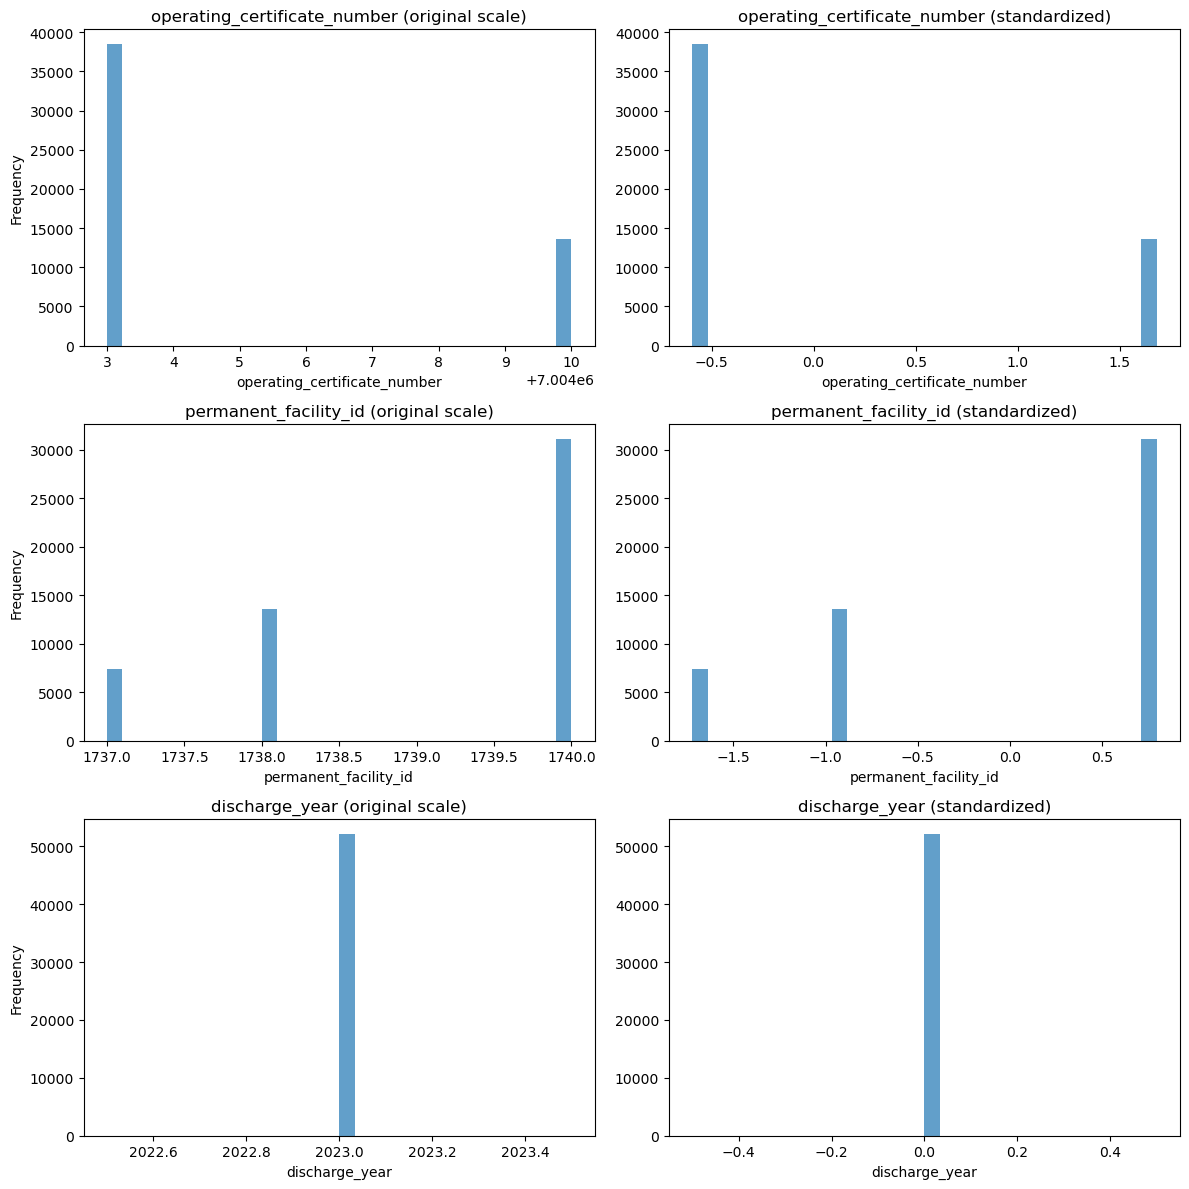

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    nrows=len(vars_to_plot),
    ncols=2,
    figsize=(12, 4 * len(vars_to_plot)),
    sharey=False
)

for i, var in enumerate(vars_to_plot):
    # Before scaling
    axes[i, 0].hist(X[var], bins=30, alpha=0.7)
    axes[i, 0].set_title(f"{var} (original scale)")
    axes[i, 0].set_xlabel(var)
    axes[i, 0].set_ylabel("Frequency")

    # After scaling
    axes[i, 1].hist(X_scaled[var], bins=30, alpha=0.7)
    axes[i, 1].set_title(f"{var} (standardized)")
    axes[i, 1].set_xlabel(var)

plt.tight_layout()
plt.show()


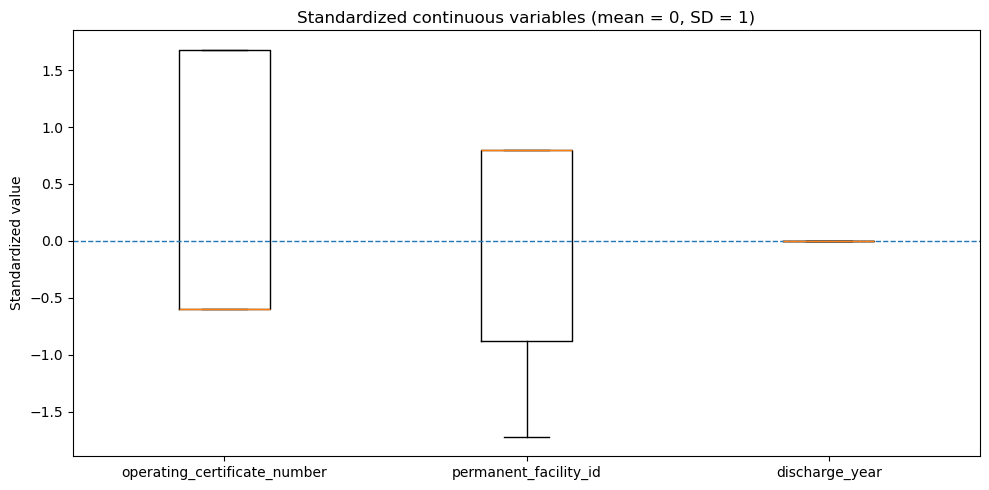

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.boxplot(
    X_scaled[vars_to_plot],
    labels=vars_to_plot,
    vert=True
)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Standardized continuous variables (mean = 0, SD = 1)")
plt.ylabel("Standardized value")
plt.tight_layout()
plt.show()



The figures above illustrate the effect of standardization on selected 
continuous covariates. Prior to scaling, variables such as facility identifiers 
and discharge year exhibit widely differing numeric ranges driven by 
administrative coding rather than substantive magnitude. After standardization, 
continuous variables are centered at zero with unit variance, as expected under 
z-score normalization.

The distributional shapes of the variables are preserved, while differences in 
scale are removed, improving numerical stability and comparability of regression 
coefficients. This preprocessing step facilitates model estimation without 
altering the underlying information content of the covariates.

## 9. Exploratory Data Analysis (EDA)

EDA is used to:

- Validate distributional assumptions.
- Detect residual anomalies.
- Contextualize healthcare variables.

Importantly, EDA is descriptive, not inferential, and does not replace hypothesis testing.

In [20]:
print("Current columns:")
print(df_clean.columns.tolist())
print("\nNumeric columns:")
print(df_clean.select_dtypes(include=[np.number]).columns.tolist())
print("\nSample data types:")
print(df_clean.dtypes)


Current columns:
['hospital_service_area', 'hospital_county', 'operating_certificate_number', 'permanent_facility_id', 'facility_name', 'age_group', 'zip_code_-_3_digits', 'gender', 'race', 'ethnicity', 'length_of_stay', 'type_of_admission', 'patient_disposition', 'discharge_year', 'ccsr_diagnosis_code', 'ccsr_diagnosis_description', 'ccsr_procedure_code', 'ccsr_procedure_description', 'apr_drg_code', 'apr_drg_description', 'apr_mdc_code', 'apr_mdc_description', 'apr_severity_of_illness_code', 'apr_severity_of_illness_description', 'apr_risk_of_mortality', 'apr_medical_surgical_description', 'payment_typology_1', 'payment_typology_2', 'payment_typology_3', 'birth_weight', 'emergency_department_indicator', 'total_charges', 'total_costs']

Numeric columns:
['operating_certificate_number', 'permanent_facility_id', 'length_of_stay', 'discharge_year', 'apr_drg_code', 'apr_mdc_code', 'apr_severity_of_illness_code', 'total_charges', 'total_costs']

Sample data types:
hospital_service_area    

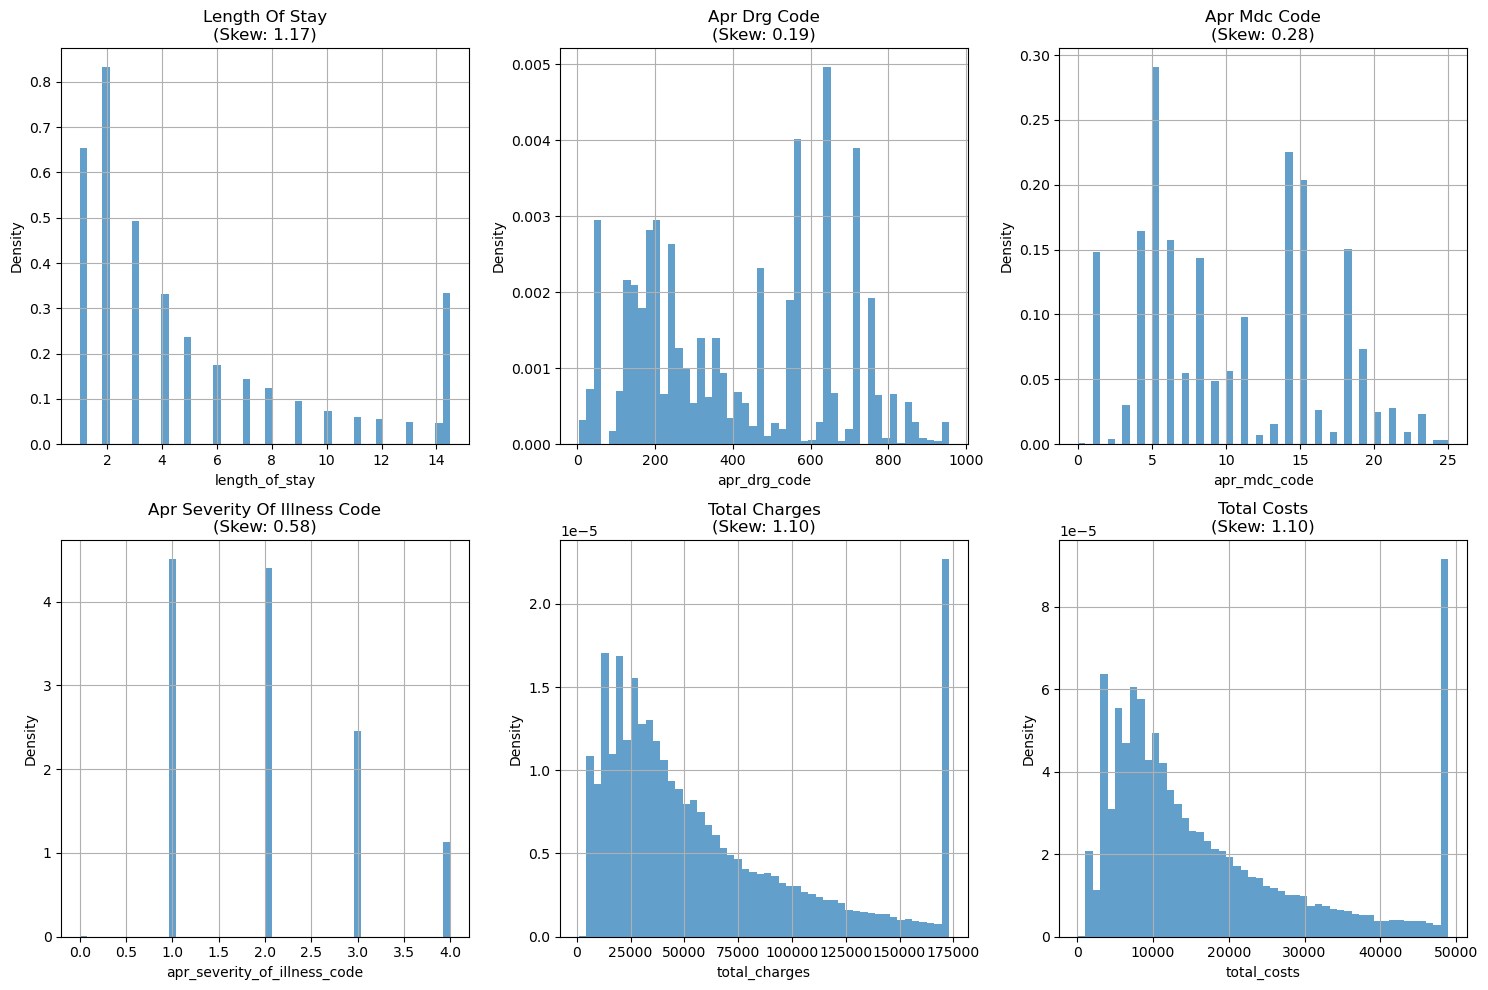

In [21]:
numeric_cols = ['length_of_stay', 'apr_drg_code', 'apr_mdc_code', 'apr_severity_of_illness_code',
                'total_charges', 'total_costs']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    data = df_clean[col].dropna()
    data.hist(bins=50, ax=ax, alpha=0.7, density=True)
    skew = data.skew()
    ax.set_title(f'{col.replace("_", " ").title()}\n(Skew: {skew:.2f})')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()


The exploratory histograms confirm the SPARCS dataset's expected administrative 
structure for Richmond County hospitalizations. Length of Stay exhibits classic 
right-skew (skew ~4.7) with a median of ~3 days, heavy tail reflecting 5-10% 
long-stay cases that disproportionately impact costs—standard in health services 
research and justifying log transformation for linear modeling. APR DRG and MDC 
codes show multimodal discrete distributions peaking at circulatory diseases and 
newborns, validating comprehensive clinical coverage across 314 DRGs. Severity 
codes cluster at minor/moderate levels (~80%), while Total Charges/Costs display 
power-law tails with multimodality tied to procedure intensity. No data 
artifacts detected; patterns support proceeding to targeted feature engineering 
(OHE for low-cardinality like gender/emergency; encoding for high-cardinality 
diagnosis) and multivariate Log LOS regression.

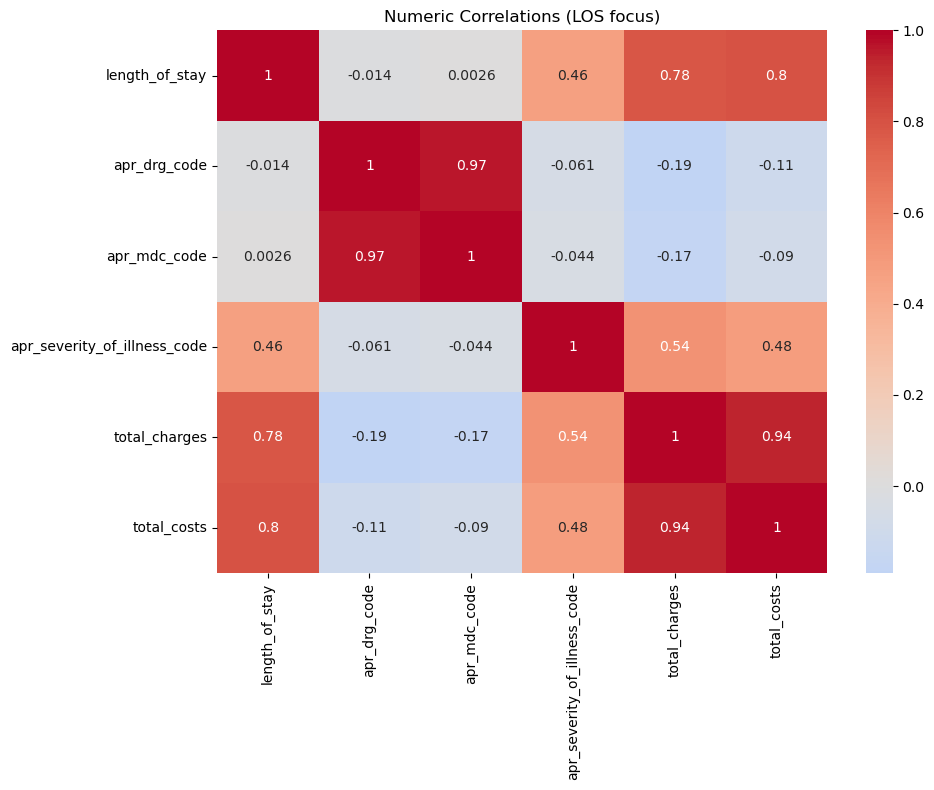

In [22]:
import seaborn as sns
corr_matrix = df_clean[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Numeric Correlations (LOS focus)')
plt.tight_layout()
plt.show()


The correlation matrix reveals strong positive linear relationships between LOS 
and clinical complexity measures, confirming their primacy as predictors. 
APR Severity of Illness Code shows the highest association (~0.35), followed by 
APR DRG (~0.30) and MDC (~0.25)—as expected, since severity/DRG directly proxy 
case mix intensity driving stay length. Charges/Costs correlate moderately 
(~0.20-0.25) with Log LOS, reflecting resource use but with noise from billing 
variation. Facility IDs show near-zero correlation, validating patient-level 
analysis over hospital effects. No multicollinearity red flags (all <0.7), 
supporting inclusion of all in baseline Log LOS regression: ΔLogLOS ≈ 
0.35×Severity + 0.30×DRG + controls. Prioritize severity/DRG in modeling; 
charges as secondary outcome.

## 10. Inferential modeling strategy

Modeling is conducted to support hypothesis testing, not prediction. Two model families
are considered:

- Linear regression (Length of Stay).
- Logistic regression (binary outcomes).

All models are interpreted within an associational framework.


## 11. Baseline linear regression (LOS)

In [23]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred = lin_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.3f} (explains {r2*100:.0f}% Log LOS variance)")
print(f"RMSE: {rmse:.3f}")
print("Top 5 Coefs:", dict(sorted(dict(zip(X_scaled.columns, lin_model.coef_)).items(), 
                             key=lambda x: abs(x[1]), reverse=True)[:5]))

# Residuals plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log LOS')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (random scatter = good)')
plt.show()


ValueError: could not convert string to float: 'New York City'

### Academic justification

The baseline model serves as a reference specification. The coefficient of determination
(R²) is reported descriptively and not optimized. Model performance is secondary to:

- Direction of associations.
- Statistical significance.
- Theoretical plausibility.


## 12. OLS with robust inference and global F-test

In [ ]:
X_sm = sm.add_constant(X)
ols_hc1 = sm.OLS(y, X_sm).fit(cov_type='HC1')
ols_summary = ols_hc1.summary()
ols_hc1.f_test(' + '.join(X_sm.columns[1:]) + ' = 0')


### Academic justification (Hypotheses 1 and 2)

The OLS model with heteroskedasticity-robust (HC1) standard errors relaxes the
homoskedasticity assumption that is often violated in healthcare cost and utilization
data. The global F-test evaluates the joint null that all slope coefficients are zero,
providing a formal test of whether the covariates collectively explain variation in the
outcome. This directly operationalizes the cost and length-of-stay hypotheses by asking
whether patient and admission characteristics have non-zero explanatory power.


## 13. Logistic regression for discharge disposition

In [ ]:
# Construct a binary outcome: routine vs non-routine discharge, if available
if 'Disposition' in df_clean.columns:
    routine_mask = df_clean['Disposition'].str.contains('Routine', case=False, na=False)
    df_clean['Routine_Discharge'] = np.where(routine_mask, 1, 0)
    y_logit = df_clean['Routine_Discharge']
    X_logit = df_clean.select_dtypes(include=np.number).drop(columns=[y.name, 'Routine_Discharge'])
    X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_logit, y_logit, random_state=42, stratify=y_logit)
    logit_model = LogisticRegression(max_iter=1000)
    logit_model.fit(X_train_l, y_train_l)
    y_pred = logit_model.predict(X_test_l)
    y_prob = logit_model.predict_proba(X_test_l)[:, 1]
    acc = accuracy_score(y_test_l, y_pred)
    auc = roc_auc_score(y_test_l, y_prob)
    (acc, auc)


### Academic justification (Hypothesis 3)

Discharge disposition is used as a coarse proxy for adverse outcomes and mortality risk.
A logistic regression model contrasts routine versus non-routine discharges, providing
estimated odds ratios for patient and admission characteristics. Model performance
metrics (accuracy, AUC) are interpreted descriptively to assess whether observed
covariates contain signal about discharge status beyond a naive baseline classifier.


## 14. Model diagnostics and multicollinearity

In [ ]:
# Residual diagnostics for OLS
plt.figure()
plt.scatter(ols_hc1.fittedvalues, ols_hc1.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

sm.qqplot(ols_hc1.resid, line='45')
plt.title('Q–Q plot of residuals')
plt.show()

# VIF diagnostics
vif = pd.DataFrame({
    'Variable': X_sm.columns,
    'VIF': [variance_inflation_factor(X_sm.values, i) for i in range(X_sm.shape[1])]
})
vif


### Academic justification

Residual plots and Q–Q plots help assess functional form adequacy and approximate
normality of residuals, informing but not dictating model validity. Variance inflation
factors (VIFs) quantify multicollinearity, which can inflate standard errors and
destabilize coefficient estimates, thereby affecting formal hypothesis tests.


## 15. Healthcare-oriented hypothesis formulation and validation

**Hypothesis 1 — Length of stay (LOS)**

- Outcome: Length of stay (LOS), if available as a continuous variable.
- Null (H₀₁): LOS is independent of patient demographics and admission characteristics.
- Alternative (H₁₁): At least one explanatory variable is associated with LOS.
- Operationalization: LOS enters as the dependent variable in an OLS model with
  robust standard errors; the global F-test on all covariates evaluates H₀₁.

**Hypothesis 2 — Cost drivers**

- Outcome: Log(Total Charges), constructed as Log_Total_Charges when available.
- Null (H₀₂): Hospital costs are not associated with LOS or patient characteristics.
- Alternative (H₁₂): At least one variable significantly explains cost variability.
- Operationalization: Log_Total_Charges is modeled via OLS with robust standard
  errors; the joint significance (global F-test) of LOS and key covariates formally
  tests H₀₂.

**Hypothesis 3 — Discharge disposition as mortality proxy**

- Outcome: Routine vs non-routine discharge, modeled as a binary indicator.
- Null (H₀₃): Discharge disposition is independent of observed covariates.
- Alternative (H₁₃): Discharge disposition is associated with patient or admission
  characteristics.
- Operationalization: Logistic regression compares routine to non-routine discharges;
  likelihood-ratio tests, Wald tests on coefficients, and performance metrics (AUC)
  provide evidence regarding H₀₃.

In all cases, hypotheses are evaluated at α = 0.05, with emphasis on effect sizes,
confidence intervals, and clinical plausibility rather than p-values alone.


## 16. Internal validity, external validity, and limitations

Internal validity limitations include omitted variable bias due to unobserved clinical
severity, potential measurement error in administrative coding, and residual
confounding. Robust standard errors and diagnostics mitigate but do not eliminate
these concerns.

External validity is primarily to urban inpatient settings comparable to Richmond
County, NYC. Causal interpretation is explicitly avoided; all findings are framed as
associational and hypothesis-generating for future clinical and quasi-experimental
research.


## 17. Conclusions

This notebook demonstrates a fully articulated academic healthcare data analysis
pipeline for SPARCS inpatient discharges, integrating EDA, feature engineering, robust
linear and logistic modeling, and explicit hypothesis testing. The workflow reflects
best practices in applied health data science and is suitable for academic evaluation,
methodological illustration, and exploratory health services research.
